In [87]:
# Import packages

import pandas as pd

import numpy as np
import _pickle as cpickle

import sys
sys.path.insert(0, '/home/ec2-user/SageMaker/mymodule/')
from common_functions import psi
from common_functions import ks
from common_functions import data_vars

from impute_functions import impute_secure
from impute_functions import impute_unsecure
from impute_functions import impute_noappl
from impute_functions import impute_pot30
from impute_functions import  impute_pot60
from impute_functions import  impute_pot90
from impute_functions import setMax


import matplotlib.pyplot as plt

%matplotlib inline
import boto3
#!pip install graphviz


In [88]:
#old s3_source_path='s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202009/'


bucket_name = 'mf-ml-ds'
s3_source = 's3://'+ bucket_name +'/Legal_Study/source'
s3_source_path  = s3_source 
s3_score_target  = 'Legal_Study/output'
# pps_score_file_name = 'xgb_weighted_score_pot_' + YYYYMM +'.csv'

psi_file_path = 's3://'+ bucket_name + '/' + s3_score_target
model_path = 'Legal_Study/final_model/'
model_path1 = 'propensity_to_pay/final_model/'

s3 = boto3.resource('s3')


In [11]:
def upload_model(model, model_name):
    with open(model_name, 'wb') as f:
        cpickle.dump(model, f)
    s3.meta.client.upload_file(model_name, bucket_name, model_path + model_name)
    

In [90]:
def download_model(model_name):
    #model_name = 'slowsecure_xgb_model_w'
    s3.meta.client.download_file(bucket_name, model_path1 + model_name, model_name)
    with open(model_name, 'rb') as f:
        xgb = cpickle.load(f)
        return xgb

In [91]:
 pot90xgb = download_model('pot90_xgb_model_v2_2')
    

start to build bk model on portfolio data

In [169]:



df_bk=pd.read_csv(s3_source_path + '/bk_model.csv')



In [226]:
df_bk.head()



,FFC_Source_Input_2,RefreshFicoScore,Loan_Type,Original_Balance,Original_PI_Constant,Original_Term,lnface,LNAPRO,UPB,number_of_prior_loans,MOBVintageUnthread,MOBVintageThread,credit_score_pm,TOTAL_INCOME,DISPOSABLE_INCOME,DEBT_RATIO_DBL,yrs_on_job_dbl,BNI,AGE,day_passed_from_app_to_open3,number_of_payments,__of_days_until_pmt_date,current_DQ,Dataforperiod,RBO,Cure,Def,FICO_migration,NumberOfCars,MaxCarValue,MaxCarYear,maxCarMile,SumCarValue,MinCarYear,MincarMile,Times29_6mo,Times30_6mo,Times60_6mo,Times90_6mo,Times29_9mo,Times30_9mo,Times60_9mo,Times90_9mo,Times29_12mo,Times30_12mo,Times60_12mo,Times90_12mo,Times29_Ever,Times30_Ever,Times60_Ever,Times90_Ever,ADA_3215,ADA_3236,ADA_3368,ADA_3480,ADA_3863,ADA_3894,ADA_3224,ADA_3336,ADA_3842,ADA_3101,ADA_3117,ADA_3143,ADA_3123,ADA_3138,ADA_3160,ADA_3203,ADA_3536,ADA_3547,ADA_3558,ADA_3569,ADA_3579,ADA_3593,ADA_3609,ADA_3725,ADA_3857,ADA_3102,ADA_3113,ADA_3124,ADA_3139,ADA_3150,ADA_3161,ADA_3183,ADA_3204,ADA_3217,ADA_3228,ADA_3239,ADA_3270,ADA_3290,ADA_3309,ADA_3320,ADA_3330,ADA_3340,ADA_3350,ADA_3356,ADA_3362,ADA_3369,ADA_3370,ADA_3380,ADA_3389,ADA_3398,ADA_3407,ADA_3417,ADA_3428,ADA_3439,ADA_3450,ADA_3537,ADA_3548,ADA_3559,ADA_3570,ADA_3583,ADA_3594,ADA_3605,ADA_3616,ADA_3627,ADA_3726,ADA_3748,ADA_3753,ADA_3756,ADA_3760,ADA_3825,ADA_3833,ADA_3837,ADA_3847,ADA_3854,ADA_3860,ADA_3866,ADA_3873,ADA_3874,ADA_3875,ADA_3889,ADA_3897,ADA_3898,ADA_3899,ADA_3900,ADA_3920,ADA_3921,ADA_3922,ADA_3936,ADA_3939,ADA_3944,ADA_3945,ADA_3946,ADA_3953,ADA_3954,ADA_3955,ADA_3966,ADA_3973,ADA_3974,ADA_3975,ADA_3976,ADA_3977,ADA_3984,ADA_3989,ADA_3140,ADA_3162,ADA_3184,ADA_3838,ADA_3848,ADA_3104,ADA_3126,ADA_3141,ADA_3152,ADA_3163,ADA_3185,ADA_3205,ADA_3219,ADA_3272,ADA_3292,ADA_3311,ADA_3322,ADA_3332,ADA_3351,ADA_3357,ADA_3363,ADA_3371,ADA_3382,ADA_3391,ADA_3400,ADA_3409,ADA_3419,ADA_3430,ADA_3441,ADA_3452,ADA_3539,ADA_3550,ADA_3561,ADA_3572,ADA_3585,ADA_3596,ADA_3607,ADA_3618,ADA_3629,ADA_3727,ADA_3749,ADA_3826,ADA_3830,ADA_3834,ADA_3839,ADA_3849,ADA_3855,ADA_3867,ADA_3876,ADA_3877,ADA_3878,ADA_3890,ADA_3923,ADA_3924,ADA_3925,ADA_3956,ADA_3957,ADA_3958,ADA_3985,ADA_3990,ADA_3100,ADA_3111,ADA_3122,ADA_3133,ADA_3135,ADA_3137,ADA_3148,ADA_3159,ADA_3181,ADA_3192,ADA_3237,ADA_3268,ADA_3288,ADA_3307,ADA_3318,ADA_3329,ADA_3338,ADA_3349,ADA_3355,ADA_3361,ADA_3367,ADA_3379,ADA_3388,ADA_3397,ADA_3406,ADA_3415,ADA_3426,ADA_3437,ADA_3448,ADA_3471,ADA_3472,ADA_3473,ADA_3474,ADA_3475,ADA_3476,ADA_3477,ADA_3478,ADA_3479,ADA_3535,ADA_3546,ADA_3557,ADA_3568,ADA_3581,ADA_3592,ADA_3603,ADA_3614,ADA_3625,ADA_3743,ADA_3746,ADA_3747,ADA_3752,ADA_3755,ADA_3759,ADA_3794,ADA_3795,ADA_3796,ADA_3797,ADA_3798,ADA_3799,ADA_3800,ADA_3801,ADA_3802,ADA_3803,ADA_3804,ADA_3805,ADA_3806,ADA_3807,ADA_3812,ADA_3813,ADA_3814,ADA_3815,ADA_3832,ADA_3843,ADA_3844,ADA_3846,ADA_3864,ADA_3865,ADA_3870,ADA_3871,ADA_3872,ADA_3888,ADA_3895,ADA_3896,ADA_3902,ADA_3903,ADA_3904,ADA_3905,ADA_3907,ADA_3908,ADA_3909,ADA_3911,ADA_3912,ADA_3913,ADA_3917,ADA_3918,ADA_3919,ADA_3935,ADA_3938,ADA_3941,ADA_3942,ADA_3943,ADA_3950,ADA_3951,ADA_3952,ADA_3965,ADA_3968,ADA_3969,ADA_3970,ADA_3971,ADA_3972,ADA_3983,ADA_3988,ADA_3105,ADA_3116,ADA_3127,ADA_3136,ADA_3142,ADA_3153,ADA_3164,ADA_3193,ADA_3206,ADA_3231,ADA_3242,ADA_3273,ADA_3293,ADA_3312,ADA_3323,ADA_3333,ADA_3352,ADA_3358,ADA_3364,ADA_3372,ADA_3383,ADA_3392,ADA_3401,ADA_3410,ADA_3420,ADA_3431,ADA_3442,ADA_3453,ADA_3540,ADA_3551,ADA_3562,ADA_3573,ADA_3586,ADA_3597,ADA_3608,ADA_3619,ADA_3630,ADA_3728,ADA_3750,ADA_3757,ADA_3761,ADA_3827,ADA_3835,ADA_3840,ADA_3858,ADA_3868,ADA_3879,ADA_3880,ADA_3881,ADA_3891,ADA_3926,ADA_3927,ADA_3928,ADA_3959,ADA_3960,ADA_3961,ADA_3986,ADA_3991,ADA_3000,ADA_3001,ADA_3002,ADA_3008,ADA_3009,ADA_3010,ADA_3011,ADA_3012,ADA_3013,ADA_3014,ADA_3015,ADA_3016,ADA_3017,ADA_3018,ADA_3019,ADA_3020,ADA_3021,ADA_3022,ADA_3023,ADA_3024,ADA_3025,ADA_3026,ADA_3027,ADA_3028,ADA_3029,ADA_3030,ADA_3031,ADA_3993,ADA_3994,ADA_3995,ADA_3165,ADA_3177,ADA_3195,ADA_3207,ADA_3580,ADA_3598,ADA_3610,ADA

In [155]:

df_bk['bkflag'].value_counts()

0.0    128176
1.0      4455
Name: bkflag, dtype: int64

In [229]:
df_bk.groupby('current_DQ').agg(count=('FFC_Source_Input_2', 'size'), bk_rate=('bkflag', 'mean')) 

,count,bk_rate
current_DQ,,
60,36644,0.036760
90,32360,0.034765
120,29595,0.032235
150,26909,0.029024
180,7124,0.034812


In [228]:
df_bk.groupby('current_DQ').agg(legalcount=('legal', 'size'), bk_rate=('bkflag', 'mean')) 

,legalcount,bk_rate
current_DQ,,
60,36644,0.036760
90,32360,0.034765
120,29595,0.032235
150,26909,0.029024
180,7124,0.034812


score up the pot90 model

In [176]:
y_oot=df_bk.bkflag
X_oot=df_bk[pot90_columns]
y_id=df_bk.FFC_Source_Input_2
impute_pot90(X_oot, ptable)
X_oot=X_oot.fillna(0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [295]:
#validation pot90 on bk flag;
oot_pred=pot90xgb.predict_proba(X_oot)[:, 1]
y_oot_hat=oot_pred
y_pred=pd.DataFrame(data=y_oot_hat, columns=['pps'], index=X_oot.index.copy())
df_pps=pd.merge(y_id, y_pred, how='left', left_index=True, right_index=True)
#convert ndarray to a dataframe, so that it can merge with true y in the merge statement
df_pps.head()



,FFC_Source_Input_2,pps
0,7702009340,0.655741
1,7882003841,0.944786
2,7882004176,0.410606
3,7102003182,0.908533
4,7102003233,0.515042


In [296]:


df_pot90=pd.merge(y_oot, df_pps, how='left', left_index=True, right_index=True)
ks_oot=ks(data=df_pot90, target='bkflag', prob='pps')


    min_score max_score  events  nonevents    total event_rate nonevent_rate  \
0    0.968638  0.994106    66.0     3117.0   3183.0      2.07%        97.93%   
1    0.949886  0.968638   123.0     3068.0   3191.0      3.85%        96.15%   
2    0.930937  0.949884   142.0     3045.0   3187.0      4.46%        95.54%   
3     0.91113  0.930932   117.0     3069.0   3186.0      3.67%        96.33%   
4    0.888265  0.911129   131.0     3055.0   3186.0      4.11%        95.89%   
5    0.857824  0.888263   115.0     3072.0   3187.0      3.61%        96.39%   
6    0.815201  0.857813    95.0     3092.0   3187.0      2.98%        97.02%   
7    0.744814  0.815196    74.0     3113.0   3187.0      2.32%        97.68%   
8    0.611778  0.744763    55.0     3132.0   3187.0      1.73%        98.27%   
9   0.0895561  0.611749    24.0     3163.0   3187.0      0.75%        99.25%   
10                        942.0    30926.0  31868.0      2.96%        97.04%   

   % events % nonevents % cum_events % 

build bk model

In [184]:
#df=df.drop(['bk_date'],axis=1)
df=df_bk.drop(['Dataforperiod', 'bk_date'],axis=1)

In [185]:
ptable = pd.DataFrame()
for col in df.columns:
    percentiles = df[col].quantile([0.01,0.99]).values
    df.loc[df[col] <= percentiles[0], col] = percentiles[0]
    df.loc[df[col] >= percentiles[1], col] = percentiles[1]
    ptable[col]=percentiles
     
    

In [116]:
ptable.to_csv('s3://mf-ml-ds/Legal_Study/output/bkcap_floor.csv')


In [186]:

df=df.fillna(0)

In [187]:
#split the model development sample into train and test sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(df.drop(['bkflag','FFC_Source_Input_2'], axis='columns'), df.bkflag, test_size=0.3, random_state=42)



In [50]:
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel
XGB=XGBClassifier(objective ='binary:logistic', n_estimators=100, min_samples_leaf=5, class_weight="balanced_subsample", randomstate=42)
sel_ = SelectFromModel(XGB, max_features=50)
sel_.fit(X_train, y_train)
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))


total features: 610
selected features: 50


In [183]:
selected_feat


Index(['Original_Balance', 'Original_Term', 'lnface', 'UPB', 'BNI',
       'Times29_6mo', 'Times90_12mo', 'Times29_Ever', 'Times30_Ever',
       'Times60_Ever', 'Times90_Ever', 'ADA_3215', 'ADA_3236', 'ADA_3368',
       'ADA_3894', 'ADA_3224', 'ADA_3101', 'ADA_3124', 'ADA_3228', 'ADA_3239',
       'ADA_3756', 'ADA_3854', 'ADA_3866', 'ADA_3826', 'ADA_3100', 'ADA_3181',
       'ADA_3474', 'ADA_3743', 'ADA_3752', 'ADA_3801', 'ADA_3846', 'ADA_3865',
       'ADA_3941', 'ADA_3965', 'ADA_3970', 'ADA_3972', 'ADA_3242', 'ADA_3573',
       'ADA_3859', 'ADA_3223', 'ADA_3745', 'ADA_3257', 'ADA_3266', 'ADA_3376',
       'ADA_3758', 'ADA_3862', 'ADA_3850', 'FPD_n', 'affiliate_flag',
       'dis_income_topmt'],
      dtype='object')

In [188]:
X_train=X_train[selected_feat]
X_test=X_test[selected_feat]


In [189]:

XGB=XGBClassifier(objective ='binary:logistic', n_estimators=150, eta=0.07, max_depth=7, min_child_weight=4, class_weight="balanced_subsample", randomstate=42)

In [101]:
XGB.fit(X_train, y_train)
XGB.score(X_test, y_test)

0.967710445295487

In [190]:
X_train3=X_train.drop(['ADA_3368','ADA_3965','ADA_3894','ADA_3215','ADA_3228','lnface','ADA_3236'], axis=1)
X_test3=X_test.drop(['ADA_3368','ADA_3965','ADA_3894','ADA_3215','ADA_3228', 'lnface','ADA_3236'], axis=1)

# X_train3=X_train
# X_test3=X_test


In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X=add_constant(X_train3)


pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

const               34.404125
Original_Balance     2.306604
Original_Term        2.125861
UPB                  2.043639
BNI                  1.729473
Times29_6mo          1.450700
Times90_12mo         6.709579
Times29_Ever         1.892831
Times30_Ever         1.756461
Times60_Ever         1.620925
Times90_Ever         7.416484
ADA_3224             9.810527
ADA_3101             1.749425
ADA_3124             1.290345
ADA_3239             2.469329
ADA_3756             1.424413
ADA_3854             2.079438
ADA_3866             2.631304
ADA_3826             1.912079
ADA_3100             2.594371
ADA_3181             3.521615
ADA_3474             3.659245
ADA_3743             1.651025
ADA_3752             7.453324
ADA_3801             1.009202
ADA_3846             5.196400
ADA_3865             3.480745
ADA_3941             2.525422
ADA_3970             5.616350
ADA_3972             4.969501
ADA_3242             2.176081
ADA_3573             1.923766
ADA_3859             1.130906
ADA_3223  

In [191]:
XGB.fit(X_train3, y_train)
XGB.score(X_test3, y_test)

0.9683086202563458

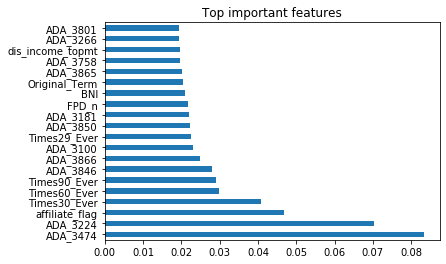

In [105]:
#rank order the variable importance
feat_importances=pd.Series(XGB.feature_importances_, index=X_train3.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top important features')
plt.show()


In [365]:
feat_importances.nlargest(20).index


Index(['ADA_3474', 'ADA_3224', 'affiliate_flag', 'Times30_Ever',
       'Times60_Ever', 'Times90_Ever', 'ADA_3846', 'ADA_3866', 'ADA_3100',
       'Times29_Ever', 'ADA_3850', 'ADA_3181', 'FPD_n', 'BNI', 'Original_Term',
       'ADA_3865', 'ADA_3758', 'dis_income_topmt', 'ADA_3266', 'ADA_3801'],
      dtype='object')

In [362]:
X_train3.columns[pd.Series(X_train3.columns).str.startswith('ADA')]

Index(['ADA_3224', 'ADA_3101', 'ADA_3124', 'ADA_3239', 'ADA_3756', 'ADA_3854',
       'ADA_3866', 'ADA_3826', 'ADA_3100', 'ADA_3181', 'ADA_3474', 'ADA_3743',
       'ADA_3752', 'ADA_3801', 'ADA_3846', 'ADA_3865', 'ADA_3941', 'ADA_3970',
       'ADA_3972', 'ADA_3242', 'ADA_3573', 'ADA_3859', 'ADA_3223', 'ADA_3745',
       'ADA_3257', 'ADA_3266', 'ADA_3376', 'ADA_3758', 'ADA_3862', 'ADA_3850'],
      dtype='object')

In [386]:
test_pred=XGB.predict_proba(X_test3)[:, 1]



In [387]:
#run the validation on test data
import pandas as pd

#merge only the test dataset
y_test_hat=test_pred
# y_test_hat
#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['BKscore'], index=X_test3.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='bkflag', prob='BKscore')

      min_score   max_score  events  nonevents    total event_rate  \
0     0.0771658     0.76823   904.0     3075.0   3979.0     22.72%   
1     0.0413405   0.0771618   189.0     3790.0   3979.0      4.75%   
2      0.025711   0.0413267   103.0     3876.0   3979.0      2.59%   
3     0.0166822   0.0257107    37.0     3942.0   3979.0      0.93%   
4     0.0112928   0.0166815    37.0     3942.0   3979.0      0.93%   
5     0.0078675   0.0112925    22.0     3957.0   3979.0      0.55%   
6     0.0054817  0.00786725    15.0     3963.0   3978.0      0.38%   
7    0.00376415  0.00548137     7.0     3973.0   3980.0      0.18%   
8    0.00241618  0.00376407     5.0     3974.0   3979.0      0.13%   
9   0.000184937  0.00241612     3.0     3976.0   3979.0      0.08%   
10                           1322.0    38468.0  39790.0      3.32%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         77.28%   68.38%       7.99%       68.38%           7.99%  60.4  
1        

In [388]:
ks_test.to_excel('bk_val_ks.xlsx')

In [389]:
df_oot=pd.read_csv(s3_source_path + '/bk_model_oot.csv')



In [390]:
df_oot2=df_oot[df_oot['Dataforperiod']=='2021-05-01']

X_oot=df_oot2[X_train3.columns]
y_oot=df_oot2.bkflag
y_id=df_oot2.FFC_Source_Input_2

In [391]:
df_oot2['legal'].value_counts()




0.0    11891
1.0     3838
Name: legal, dtype: int64

In [392]:
ptable=pd.read_csv('s3://mf-ml-ds/Legal_Study/output/bkcap_floor.csv')

In [393]:
    for col in X_oot.columns:
        p1 = ptable[col].min()
        p99= ptable[col].max()
    
        X_oot.loc[X_oot[col] <= p1, col] = p1
        X_oot.loc[X_oot[col] >= p99, col] = p99

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [394]:
X_oot=X_oot.fillna(0)

In [395]:
test_pred=XGB.predict_proba(X_oot)[:, 1]

In [396]:
import pandas as pd

#merge only the test dataset
y_pred=test_pred

y_pred_df=pd.DataFrame(data=y_pred, columns=['bkscore'], index=X_oot.index.copy())

df_bkscore=pd.merge(y_id, y_pred_df, how='left', left_index=True, right_index=True)

df_out=pd.merge(y_oot, y_pred_df, how='left', left_index=True, right_index=True)
ks_oot=ks(data=df_out, target='bkflag', prob='bkscore')

      min_score   max_score  events  nonevents    total event_rate  \
0     0.0745229    0.832765   301.0     1272.0   1573.0     19.14%   
1     0.0399897   0.0744605    75.0     1498.0   1573.0      4.77%   
2     0.0243716   0.0399644    35.0     1538.0   1573.0      2.23%   
3     0.0160907   0.0243713    23.0     1550.0   1573.0      1.46%   
4     0.0106701   0.0160901    20.0     1553.0   1573.0      1.27%   
5    0.00740612   0.0106664    16.0     1557.0   1573.0      1.02%   
6    0.00523289  0.00740408     8.0     1564.0   1572.0      0.51%   
7    0.00369622  0.00523248     4.0     1569.0   1573.0      0.25%   
8    0.00239892  0.00369605     3.0     1570.0   1573.0      0.19%   
9   0.000237217  0.00239779     4.0     1569.0   1573.0      0.25%   
10                            489.0    15240.0  15729.0      3.11%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         80.86%   61.55%       8.35%       61.55%           8.35%  53.2  
1        

In [397]:
ks_oot.to_excel('bk_oot_ks.xlsx')

In [399]:
y_pred_df=df_oot2['BNI']
df_out=pd.merge(y_oot, y_pred_df, how='left', left_index=True, right_index=True)
ks_bni=ks(data=df_out, target='bkflag', prob='BNI')

   min_score max_score  events  nonevents   total event_rate nonevent_rate  \
0        326       491    10.0      729.0   739.0      1.35%        98.65%   
1        299       325    25.0      726.0   751.0      3.33%        96.67%   
2        275       298    17.0      744.0   761.0      2.23%        97.77%   
3        247       274    26.0      743.0   769.0      3.38%        96.62%   
4        222       246    26.0      697.0   723.0      3.60%        96.40%   
5        197       221    29.0      741.0   770.0      3.77%        96.23%   
6        176       196    28.0      710.0   738.0      3.79%        96.21%   
7        155       175    41.0      742.0   783.0      5.24%        94.76%   
8        115       154    46.0      713.0   759.0      6.06%        93.94%   
9          1       114    58.0      703.0   761.0      7.62%        92.38%   
10                       306.0     7248.0  7554.0      4.05%        95.95%   

   % events % nonevents % cum_events % cum_nonevents    KS  
0 

In [400]:
ks_bni.to_excel('bni_oot_ks.xlsx')

In [350]:
#merge the pps score and bk score with the original data;
df_bkscore.head()

,FFC_Source_Input_2,bkscore
1,7882003841,0.006916
3,7102003182,0.032749
4,7102003233,0.006873
9,3507006949,0.078754
11,3507007026,0.049766


In [351]:

pot90_columns=pot90xgb.get_booster().feature_names
ptable=pd.read_csv('../propensity_to_pay/model_monitor/pot90_capfloor.csv')
X_oot=df_oot2[pot90_columns]
y_id=df_oot2.FFC_Source_Input_2
impute_pot90(X_oot, ptable)
X_oot=X_oot.fillna(0)
test_pred=pot90xgb.predict_proba(X_oot)[:, 1]




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [352]:
y_pred=test_pred

y_pred_df=pd.DataFrame(data=y_pred, columns=['pps'], index=X_oot.index.copy())

df_pps=pd.merge(y_id, y_pred_df, how='left', left_index=True, right_index=True)


In [353]:
df_pps.head()


,FFC_Source_Input_2,pps
1,7882003841,0.944786
3,7102003182,0.908533
4,7102003233,0.515042
9,3507006949,0.821546
11,3507007026,0.847915


In [377]:
df_sub=df_oot2[['FFC_Source_Input_2','bkflag','legal','UPB', 'current_DQ']]
df_ppsbkscore_all=pd.merge(df_pps, df_bkscore, on='FFC_Source_Input_2')
df_ppsbkscore_all=pd.merge(df_ppsbkscore_all, df_sub,on='FFC_Source_Input_2' )

In [378]:
df_ppsbkscore_all.shape

(15730, 7)

In [379]:
df_ppsbkscore_all['bucket_bk'] = pd.qcut(df_ppsbkscore_all['bkscore'], 10)
df_ppsbkscore_all['bucket_pps'] = pd.qcut(df_ppsbkscore_all['pps'], 10)
df_ppsbkscore_all.groupby('bucket_pps')['bkflag','legal','UPB'].mean()




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


,bkflag,legal,UPB
bucket_pps,,,
"(0.0886, 0.613]",0.006357,0.162111,1377.352949
"(0.613, 0.747]",0.019708,0.201526,2015.662215
"(0.747, 0.816]",0.026701,0.247298,2192.448353
"(0.816, 0.858]",0.029879,0.267006,2329.832975
"(0.858, 0.888]",0.034329,0.290528,2375.944504
"(0.888, 0.91]",0.048951,0.323586,2484.077069
"(0.91, 0.93]",0.038804,0.303435,2485.601507
"(0.93, 0.949]",0.047044,0.287985,2485.761049
"(0.949, 0.968]",0.041958,0.247298,2360.999078


In [380]:
df_ppsbkscore_all.to_excel('portfolio_legal_selection.xlsx')

# validate on the legal accounts for bk score

In [92]:
df_legal=pd.read_csv('s3://mf-ml-ds/Legal_Study/source/nation_legal_data.csv',encoding='latin1')
X_oot=df_legal[['Original_Balance', 'Original_Term', 'UPB', 'BNI',
       'Times29_6mo', 'Times90_12mo', 'Times29_Ever', 'Times30_Ever',
       'Times60_Ever', 'Times90_Ever', 'ADA_3224', 'ADA_3101', 'ADA_3124', 'ADA_3239',
       'ADA_3756', 'ADA_3854', 'ADA_3866', 'ADA_3826', 'ADA_3100', 'ADA_3181',
       'ADA_3474', 'ADA_3743', 'ADA_3752', 'ADA_3801', 'ADA_3846', 'ADA_3865',
       'ADA_3941', 'ADA_3970', 'ADA_3972', 'ADA_3242', 'ADA_3573',
       'ADA_3859', 'ADA_3223', 'ADA_3745', 'ADA_3257', 'ADA_3266', 'ADA_3376',
       'ADA_3758', 'ADA_3862', 'ADA_3850', 'FPD_n', 'affiliate_flag',
       'dis_income_topmt']]

y_id=df_legal.Account_Number_With_Branch
ptable=pd.read_csv('s3://mf-ml-ds/Legal_Study/output/bkcap_floor.csv')


In [93]:
df_legal['AMT_Recovered_Final'].mean()

289.5862653351134

In [94]:
   for col in X_oot.columns:
        p1 = ptable[col].min()
        p99= ptable[col].max()
    
        X_oot.loc[X_oot[col] <= p1, col] = p1
        X_oot.loc[X_oot[col] >= p99, col] = p99
X_oot=X_oot.fillna(0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [95]:
def download_model(model_name):
    #model_name = 'slowsecure_xgb_model_w'
    s3.meta.client.download_file(bucket_name, model_path + model_name, model_name)
    with open(model_name, 'rb') as f:
        xgb = cpickle.load(f)
        return xgb
    
XGB_BK=download_model('highDQ_BK_XGB')

In [96]:
test_pred=XGB_BK.predict_proba(X_oot)[:, 1]



In [98]:
y_oot=df_legal.BKflag
y_test_hat=test_pred
# y_test_hat
#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['bkscore'], index=X_oot.index.copy())
df_legal_bk=pd.merge(y_id, y_test_hat_df, how='left', left_index=True, right_index=True)
df_out=pd.merge(y_oot, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='BKflag', prob='bkscore')

      min_score   max_score  events  nonevents  total event_rate  \
0      0.114632    0.795804     592       1731   2323     25.48%   
1     0.0688043    0.114569     242       2081   2323     10.42%   
2     0.0457157   0.0688015     192       2131   2323      8.27%   
3     0.0320753   0.0457016     151       2172   2323      6.50%   
4      0.022683   0.0320635     117       2206   2323      5.04%   
5     0.0157385   0.0226799      95       2228   2323      4.09%   
6     0.0108089    0.015737      75       2248   2323      3.23%   
7    0.00705993   0.0108086      56       2267   2323      2.41%   
8    0.00407224  0.00705938      57       2266   2323      2.45%   
9   0.000455318  0.00406837      26       2298   2324      1.12%   
10                             1603      21628  23231      6.90%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         74.52%   36.93%       8.00%       36.93%           8.00%  28.9  
1         89.58%   15.10%       9

In [278]:
ks_test.to_excel('legal_bkscore_ks.xlsx')


score up the pot90 model

In [99]:

pot90_columns=pot90xgb.get_booster().feature_names
ptable=pd.read_csv('../propensity_to_pay/model_monitor/pot90_capfloor.csv')
y_oot=df_legal.badflag
X_oot=df_legal[pot90_columns]
y_id=df_legal.Account_Number_With_Branch
impute_pot90(X_oot, ptable)
X_oot=X_oot.fillna(0)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [100]:
#merge only the validation dataset for bad definition for legal accounts;
oot_pred=pot90xgb.predict_proba(X_oot)[:, 1]
y_oot_hat=oot_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_oot_hat_df=pd.DataFrame(data=y_oot_hat, columns=['pps'], index=X_oot.index.copy())
df_legal_pps=pd.merge(y_id, y_oot_hat_df, how='left', left_index=True, right_index=True)
df_out=pd.merge(y_oot, y_oot_hat_df, how='left', left_index=True, right_index=True)
ks_oot=ks(data=df_out, target='badflag', prob='pps')

   min_score max_score  events  nonevents  total event_rate nonevent_rate  \
0   0.957442  0.997002    2043        280   2323     87.95%        12.05%   
1   0.941156  0.957435    1990        333   2323     85.67%        14.33%   
2   0.926657  0.941145    1924        399   2323     82.82%        17.18%   
3   0.912075  0.926651    1864        459   2323     80.24%        19.76%   
4   0.895674  0.912073    1864        459   2323     80.24%        19.76%   
5   0.876479   0.89567    1771        552   2323     76.24%        23.76%   
6   0.851776  0.876478    1725        598   2323     74.26%        25.74%   
7   0.817624  0.851757    1618        705   2323     69.65%        30.35%   
8   0.752875  0.817614    1514        809   2323     65.17%        34.83%   
9   0.197312  0.752799    1305       1019   2324     56.15%        43.85%   
10                       17618       5613  23231     75.84%        24.16%   

   % events % nonevents % cum_events % cum_nonevents    KS  
0    11.60%   

In [101]:
df_legal['success']=df_legal.apply(lambda row: 1-row.badflag, axis=1)
df_legal['recover_upb_ratio']=df_legal.apply(lambda row: row.AMT_Recovered_Final/row.UPBAtEventDate, axis=1)
df_legal['chargeoff_ratio']=df_legal.apply(lambda row: row.chargeoff_amount/row.UPBAtEventDate, axis=1)
df_legal=pd.merge(df_legal, df_legal_bk, on='Account_Number_With_Branch')
df_legal=pd.merge(df_legal, df_legal_pps, on='Account_Number_With_Branch')

In [103]:
df_legal['chargeoff_ratio'].mean()

0.699003617623149

In [104]:

df_legal.groupby('Current_DQ').agg(count=('Account_Number_With_Branch', 'size'), upb=('UPBAtEventDate', 'mean'), success_rate=('success', 'mean'), payment=('AMT_Recovered_Final', 'mean'), bk_rate=('BKflag','mean')) 


,count,upb,success_rate,payment,bk_rate
Current_DQ,,,,,
60,11774,2919.980224,0.278920,324.863950,0.078733
90,5387,2930.364910,0.221459,271.792493,0.063486
120,2635,2957.338698,0.195825,244.414569,0.061101
150,2213,2911.015427,0.176683,215.551554,0.052418
180,1228,3110.200269,0.186482,258.335700,0.046417


In [105]:
df_legal.groupby('success').agg(count=('Account_Number_With_Branch', 'size'),upb=('UPBAtEventDate', 'mean'), payment=('AMT_Recovered_Final', 'mean'))

,count,upb,payment
success,,,
0,17624,3009.914620,48.859960
1,5613,2703.185143,1045.122143


In [106]:
df_legal['bucket_pps'] = pd.qcut(df_legal['pps'], 10)
df_legal['bucket_bkscore'] = pd.qcut(df_legal['bkscore'], 10)
df_legal.groupby('bucket_pps').agg(count=('Account_Number_With_Branch', 'size'),   upb=('UPBAtEventDate','mean'), success_rate=('success', 'mean'), payment=('AMT_Recovered_Final', 'mean'), recover_upb_ratio= ('recover_upb_ratio', 'mean'), bk_rate=('BKflag','mean'), chargeoff_ratio=('chargeoff_ratio','mean')) 



,count,upb,success_rate,payment,recover_upb_ratio,bk_rate,chargeoff_ratio
bucket_pps,,,,,,,
"(0.196, 0.753]",2324,3174.513219,0.438468,542.450495,0.230225,0.037005,0.469764
"(0.753, 0.818]",2324,3020.874755,0.348537,420.124131,0.171751,0.043029,0.569112
"(0.818, 0.852]",2324,3005.595194,0.302926,372.868399,0.148400,0.050344,0.619899
"(0.852, 0.876]",2323,3052.549841,0.257426,303.085174,0.124161,0.055962,0.672958
"(0.876, 0.896]",2324,3005.127005,0.237522,267.061738,0.112646,0.061102,0.699311
"(0.896, 0.912]",2323,2918.499660,0.197159,242.173052,0.098982,0.060267,0.729759
"(0.912, 0.927]",2324,2848.235219,0.197935,232.916123,0.101596,0.068847,0.757075
"(0.927, 0.941]",2323,2814.181967,0.171761,199.087718,0.084166,0.075764,0.777799
"(0.941, 0.957]",2324,2791.537345,0.143287,168.340439,0.072406,0.083477,0.818532


In [111]:
df_legal.groupby('bucket_bkscore').agg(count=('Account_Number_With_Branch', 'size'),   upb=('UPBAtEventDate','mean'), success_rate=('success', 'mean'), payment=('AMT_Recovered_Final', 'mean'), recover_upb_ratio= ('recover_upb_ratio', 'mean'), bk_rate=('BKflag','mean'), chargeoff_ratio=('chargeoff_ratio','mean')) 

,count,upb,success_rate,payment,recover_upb_ratio,bk_rate,chargeoff_ratio
bucket_bkscore,,,,,,,
"(-0.000545, 0.00407]",2324,2045.049789,0.296902,330.673404,0.189432,0.011188,0.659467
"(0.00407, 0.00705]",2324,2352.055207,0.268933,271.876725,0.135802,0.024527,0.680533
"(0.00705, 0.0108]",2323,2556.997787,0.281533,306.852419,0.145640,0.024107,0.667158
"(0.0108, 0.0157]",2324,2692.826256,0.280551,307.373120,0.132898,0.032272,0.673209
"(0.0157, 0.0227]",2324,2826.331299,0.259036,309.553537,0.129638,0.040878,0.673282
"(0.0227, 0.032]",2323,3003.693168,0.247525,318.349488,0.127424,0.050366,0.673212
"(0.032, 0.0457]",2324,3250.547306,0.241824,296.977388,0.103443,0.064974,0.697156
"(0.0457, 0.0688]",2323,3356.212802,0.211365,277.554331,0.092454,0.082221,0.723620
"(0.0688, 0.115]",2324,3504.812466,0.185886,251.192108,0.082001,0.104561,0.743881


In [84]:
df_legal['bucket_upb'] = pd.qcut(df_legal['UPBAtEventDate'], 10)
df_legal.groupby('bucket_upb').agg(count=('Account_Number_With_Branch', 'size'), success_rate=('success', 'mean'),payment=('AMT_Recovered_Final', 'mean'), bk_rate=('BKflag','mean')) 


,count,success_rate,payment,bk_rate
bucket_upb,,,,
"(-1416.1009999999999, 1225.0]",2349,0.305236,216.818676,0.043423
"(1225.0, 1500.142]",2323,0.262161,216.916164,0.043048
"(1500.142, 1918.08]",2335,0.274946,248.612321,0.055246
"(1918.08, 2280.544]",2336,0.250856,260.475980,0.057363
"(2280.544, 2584.33]",2336,0.256849,285.615839,0.065068
"(2584.33, 2858.736]",2335,0.239400,288.133683,0.062099
"(2858.736, 3339.294]",2336,0.224743,281.688930,0.074486
"(3339.294, 3929.784]",2335,0.215418,288.771897,0.086081
"(3929.784, 5115.804]",2336,0.199058,337.530146,0.098459


In [113]:
# use the decile based on monthly pot90 score distribution
# create a list of our conditions
conditions = [
    (df_legal['pps'] <= 0.635),
    (df_legal['pps'] > 0.635) & (df_legal['pps'] <= 0.772),
    (df_legal['pps'] > 0.772) & (df_legal['pps'] <= 0.84),
    (df_legal['pps'] > 0.84) & (df_legal['pps'] <= 0.88),
        (df_legal['pps'] > 0.88) & (df_legal['pps'] <= 0.906),
        (df_legal['pps'] > 0.906) & (df_legal['pps'] <= 0.926),
        (df_legal['pps'] > 0.926) & (df_legal['pps'] <= 0.943),
        (df_legal['pps'] > 0.943) & (df_legal['pps'] <= 0.958),
        (df_legal['pps'] > 0.958) & (df_legal['pps'] <= 0.972),
        (df_legal['pps'] > 0.972) & (df_legal['pps'] <= 0.999),
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3, 4,5,6,7,8,9,10]

# create a new column and use np.select to assign values to it using our lists as arguments
df_legal['decile'] = np.select(conditions, values)



In [116]:
df_legal.groupby('decile').agg(count=('Account_Number_With_Branch', 'size'), success_rate=('success', 'mean'),payment=('AMT_Recovered_Final', 'mean'), upb=('UPBAtEventDate','mean')) 

,count,success_rate,payment,upb
decile,,,,
1,675,0.518519,617.304726,3110.907837
2,2154,0.403900,500.733041,3143.500014
3,3180,0.324843,401.958925,3025.288060
4,3699,0.262774,303.740465,3038.520197
5,3335,0.220390,263.244882,2975.762402
6,3104,0.198454,235.181414,2860.492249
7,2728,0.168988,195.298321,2805.549153
8,2117,0.146906,171.150406,2792.402702
9,1459,0.140507,181.168026,2760.646402


In [ ]:
df_legal_output=df_legal[['bucket_bkscore','bucket_pps','success','BKflag','Account_Number_With_Branch','Current_DQ','UPBAtEventDate','AMT_Recovered_Final','chargeoff_amount', 'state', 'decile']]

In [ ]:
df_legal_output.to_excel('df_legal_output_v1.xlsx')

In [361]:
upload_model(XGB, 'highDQ_BK_XGB')